### Meta-connectivity

Plotting meta-connectivity

In [2]:
# Adding GDa to path
import os
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import brainconn as bc
import numpy as np
import xarray as xr
from tqdm import tqdm

from config import sessions
from GDa.graphics import plot
from GDa.net.layerwise import compute_network_partition
from GDa.util import _extract_roi

#### Plotting and file saving configurations

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

#### Loading meta-connectivity

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda")
_RESULTS = "Results/lucy/meta_conn"
_MCPATH = os.path.join(_ROOT, _RESULTS, f"MC_coh_141017.nc")

MC = xr.load_dataarray(_MCPATH)

#### Detecting communities in the MC matrix

In [16]:
len(MC.sources)

4371

In [24]:
MC[..., 0, 0]

<xarray.DataArray (sources: 4371, targets: 4371)>
array([[1.        , 0.16537683, 0.38738448, ..., 0.04509066, 0.0780623 ,
        0.1017755 ],
       [0.16537683, 1.        , 0.18219267, ..., 0.03640201, 0.01080869,
        0.06090855],
       [0.38738448, 0.18219267, 1.        , ..., 0.02921462, 0.01274001,
        0.08727515],
       ...,
       [0.04509066, 0.03640201, 0.02921462, ..., 1.        , 0.61892457,
        0.43219021],
       [0.0780623 , 0.01080869, 0.01274001, ..., 0.61892457, 1.        ,
        0.39248393],
       [0.1017755 , 0.06090855, 0.08727515, ..., 0.43219021, 0.39248393,
        1.        ]])
Coordinates:
  * sources  (sources) object 'a46D-a8B' 'a46D-F6' ... 'V1-V1' 'V1-V1'
  * targets  (targets) object 'a46D-a8B' 'a46D-F6' ... 'V1-V1' 'V1-V1'
    freqs    float64 3.0
Attributes:
    nC:               94
    fsample:          1000.0
    channels_labels:  [  1   4   8   9  10  11  12  13  14  15  16  17  18  1...
    stim:             [4. 2. 1. 2. 1. 2. 2. 1. 2. 2. 2. 4. 5. 3. 3. 5. 2. 1. ...
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ...
    t_cue_on:         [1063. 1015.  829. 1055.  878. 1049.  838.  959. 1021. ...
    t_cue_off:        [1569. 1535. 1335. 1562. 1398. 1568. 1344. 1465. 1540. ...
    t_match_on:       [2835. 2615. 2348. 2748. 2558. 2755. 2397. 2492. 2607. ...
    sources:          [ 0  0  0 ... 91 91 92]
    targets:          [ 1  2  3 ... 92 93 93]
    sfreq:            1000.0
    sm_times:         15
    sm_freqs:         1
    sm_kernel:        square
    mode:             multitaper
    n_cycles:         [ 0.75  2.75  4.75  6.75  8.75 10.75 12.75 14.75 16.75 ...
    mt_bandwidth:     None
    decim:            20
    type:             coh
    areas:            ['a46D', 'a8B', 'F6', 'a9/46D', 'a8M', 'a8B', 'a8B', 'F...
    bias:             [0.29411765 0.29411765 0.29411765 0.29411765 0.29411765...
    d_eu:             [ 89.05054744 116.09048195  89.47066558 ...  82.0243866...

In [21]:
s, t = MC.attrs["sources"], MC.attrs["targets"]

In [25]:
M = MC[..., 0, 0]

In [27]:
i = 10

In [33]:
M.values[np.ix_(s == 10, t == 10)].shape

(83, 10)

In [50]:
idx = np.logical_or(s == 10, t == 10)

In [152]:
targets, sources = np.tril_indices(6, -1)

In [153]:
data = np.random.normal(0, 1, size=(len(targets), 100))

In [154]:
roi = [f"{s}-{t}" for s, t in zip(sources, targets)]

In [155]:
data = xr.DataArray(data, dims=("roi", "times"), coords={"roi": roi})

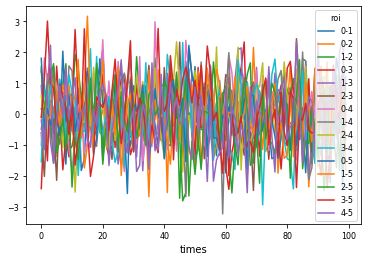

In [156]:
data.plot(x="times", hue="roi")

In [174]:
MC = xr.DataArray(np.corrcoef(data), dims=("sources", "targets"), coords=(roi, roi))

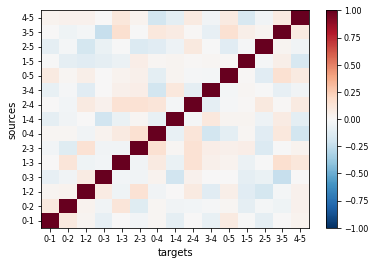

In [175]:
MC.plot.imshow()

In [176]:
idx = np.logical_or(sources == 2, targets == 2)

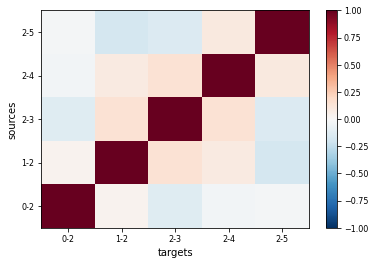

In [177]:
MC.isel(sources=idx, targets=idx).plot.imshow()

In [169]:
a = MC.data

In [171]:
a = a[np.ix_(idx, idx)]

In [165]:
(
    MC.sel(sources="0-2", targets="0-1")
    + MC.sel(sources="0-3", targets="0-1")
    + MC.sel(sources="0-4", targets="0-1")
    + MC.sel(sources="0-5", targets="0-1")
    + MC.sel(sources="0-2", targets="0-3")
    + MC.sel(sources="0-4", targets="0-2")
    + MC.sel(sources="0-5", targets="0-2")
    + MC.sel(sources="0-3", targets="0-4")
    + MC.sel(sources="0-3", targets="0-5")
    + MC.sel(sources="0-4", targets="0-5")
)

<xarray.DataArray ()>
array(0.07062988)
Coordinates:
    targets  <U3 '0-5'

In [172]:
np.triu(a, 1).sum()

0.07062987735535534

In [173]:
np.max([sources, targets])

5

In [318]:
def _trimmer_strengths(meta_conn, sources, targets, n_nodes=None):
    """Given a MC matrix it computes the trimmer strengths for each node"""
    # Get the number of nodes
    if n_nodes == None:
        n_nodes = np.max([sources, targets]) + 1
    # Store trimmer-strengths for each node
    ts = np.zeros(n_nodes)
    for i in range(n_nodes):
        # Get indexes where node i is present
        idx = np.logical_or(sources == i, targets == i)
        # Get sub-matrix only with meta-edges containing i
        sub_mat = meta_conn[np.ix_(idx, idx)]
        ts[i] = np.triu(sub_mat, 1).sum(axis=(0, 1))
    return ts

In [344]:
from frites.utils import parallel_func


def tensor_trimmer_strengths(meta_conn, n_jobs=1, verbose=False):

    assert isinstance(meta_conn, xr.DataArray)
    assert meta_conn.ndim == 4
    assert "sources" in meta_conn.attrs.keys() and "targets" in meta_conn.attrs.keys()

    areas = meta_conn.attrs["areas"]
    freqs, times = meta_conn.freqs.data, meta_conn.times.data
    # Number of times and freqs layers
    n_times, n_freqs = len(times), len(freqs)
    # Compute total number of layers
    n_layers = n_times * n_freqs
    # Get list of sources and targets
    sources, targets = meta_conn.attrs["sources"], meta_conn.attrs["targets"]
    # Number of nodes
    n_nodes = np.max([sources, targets]) + 1

    # Stack freqs and times layers
    meta_conn = meta_conn.stack(layers=("freqs", "times"))

    def _for_layer(n):
        return _trimmer_strengths(
            meta_conn[..., n].data, sources, targets, n_nodes=n_nodes
        )

    # Define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_layer, n_jobs=n_jobs, verbose=verbose, total=n_layers
    )
    # Compute the single trial coherence
    ts = parallel(p_fun(n) for n in range(n_layers))
    # Convert to numpy array
    ts = np.stack(ts, -1)

    # Unstack trials and time
    ts = ts.reshape((n_nodes, n_freqs, n_times))
    # Convert to xarray
    ts = xr.DataArray(
        ts,
        dims=("roi", "freqs", "times"),
        coords={"roi": areas, "freqs": freqs, "times": times},
    )
    return ts

In [345]:
ts = trimmer_strengths(MC[..., 0, 0].values, MC.attrs["sources"], MC.attrs["targets"])

In [346]:
ts = tensor_trimmer_strengths(MC)

  0%|          |  : 0/50 [00:00<?,       ?it/s]

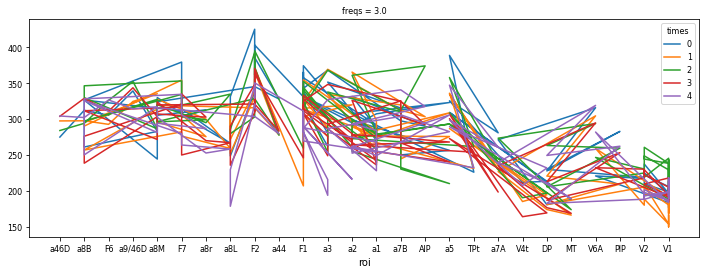

In [350]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
ts.isel(freqs=0).plot(x="roi", hue="times")

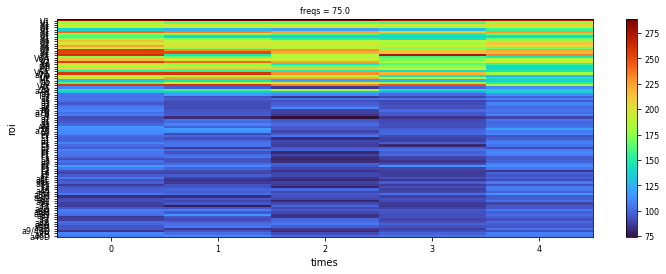

In [364]:
plt.figure(figsize=(12, 4))
ts.isel(freqs=9).plot.imshow(x="times", y="roi", cmap="turbo")

In [394]:
x_s, x_t = _extract_roi(MC.sources.data, "-")

In [395]:
a1 = np.concatenate((x_s, x_t))

In [396]:
a2 = np.concatenate((MC.attrs["sources"], MC.attrs["targets"]))

In [405]:
x_s

array(['a46D', 'a46D', 'a46D', ..., 'V1', 'V1', 'V1'], dtype='<U6')

In [406]:
MC.attrs["sources"]

array([ 0,  0,  0, ..., 91, 91, 92])

In [408]:
MC.attrs["areas"]

['a46D',
 'a8B',
 'F6',
 'a9/46D',
 'a8M',
 'a8B',
 'a8B',
 'F7',
 'F7',
 'a8r',
 'a8M',
 'a8M',
 'a8B',
 'F7',
 'F7',
 'a8L',
 'a8r',
 'a8M',
 'a8M',
 'F2',
 'a44',
 'F2',
 'F2',
 'a8L',
 'a8L',
 'a8L',
 'F2',
 'F2',
 'F2',
 'F2',
 'F1',
 'F1',
 'a3',
 'a3',
 'F1',
 'F1',
 'F1',
 'F1',
 'a2',
 'F1',
 'F1',
 'a1',
 'a1',
 'F1',
 'F1',
 'a3',
 'a7B',
 'AIP',
 'a2',
 'a1',
 'a1',
 'a1',
 'a3',
 'a7B',
 'a7B',
 'a5',
 'a2',
 'a2',
 'a1',
 'a5',
 'a2',
 'TPt',
 'a5',
 'a7A',
 'a5',
 'V4t',
 'DP',
 'a5',
 'MT',
 'DP',
 'a7A',
 'V6A',
 'DP',
 'PIP',
 'DP',
 'V2',
 'V2',
 'V6A',
 'V1',
 'V1',
 'V2',
 'V2',
 'V1',
 'V2',
 'V2',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1']

In [392]:
a1s[a2s == 1]

array(['a8B', 'a5', 'a7A', 'a8B', 'a8B', 'a8B', 'a5', 'a5', 'a2', 'a1',
       'a1', 'a2', 'a2', 'a5', 'a7B', 'a7B', 'a3', 'a1', 'a1', 'a8B',
       'a5', 'a7A', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B',
       'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B',
       'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a2', 'a8B',
       'a7B', 'a8B', 'a44', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B',
       'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B',
       'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a3', 'a8B',
       'a8B', 'a1', 'a1', 'a8B', 'a8B', 'a2', 'a8B', 'a8B', 'a8B', 'a8B',
       'a3', 'a3', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B', 'a8B'],
      dtype='<U6')

In [384]:
MC.attrs["areas"]

['a46D',
 'a8B',
 'F6',
 'a9/46D',
 'a8M',
 'a8B',
 'a8B',
 'F7',
 'F7',
 'a8r',
 'a8M',
 'a8M',
 'a8B',
 'F7',
 'F7',
 'a8L',
 'a8r',
 'a8M',
 'a8M',
 'F2',
 'a44',
 'F2',
 'F2',
 'a8L',
 'a8L',
 'a8L',
 'F2',
 'F2',
 'F2',
 'F2',
 'F1',
 'F1',
 'a3',
 'a3',
 'F1',
 'F1',
 'F1',
 'F1',
 'a2',
 'F1',
 'F1',
 'a1',
 'a1',
 'F1',
 'F1',
 'a3',
 'a7B',
 'AIP',
 'a2',
 'a1',
 'a1',
 'a1',
 'a3',
 'a7B',
 'a7B',
 'a5',
 'a2',
 'a2',
 'a1',
 'a5',
 'a2',
 'TPt',
 'a5',
 'a7A',
 'a5',
 'V4t',
 'DP',
 'a5',
 'MT',
 'DP',
 'a7A',
 'V6A',
 'DP',
 'PIP',
 'DP',
 'V2',
 'V2',
 'V6A',
 'V1',
 'V1',
 'V2',
 'V2',
 'V1',
 'V2',
 'V2',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1']

In [411]:
ts.to_dataframe("ts").reset_index()

,roi,freqs,times,ts
0,a46D,3.0,0,274.947261
1,a46D,3.0,1,297.431379
2,a46D,3.0,2,284.058815
3,a46D,3.0,3,303.882072
4,a46D,3.0,4,304.293042
...,...,...,...,...
4695,V1,75.0,0,277.054762
4696,V1,75.0,1,288.424468
4697,V1,75.0,2,285.501099
4698,V1,75.0,3,271.230312
